In [5]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt



In [6]:

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
data = train.append(test,sort=False)

In [8]:
data = data.drop(['Alley','FireplaceQu','PoolQC','Fence','MiscFeature',],axis=1)

In [11]:
#filling nan values with mean of respective columns
data = data.fillna(data.mean())

In [13]:
data = pd.get_dummies(data)

In [14]:
covarianceMatrix = data.corr()
listOfFeatures = [i for i in covarianceMatrix]
dropfeatures = set()

for i in range(len(listOfFeatures)):
    for j in range(i+1,len(listOfFeatures)):
        feature1 = listOfFeatures[i]
        feature2 = listOfFeatures[j]
        if(covarianceMatrix[feature1][feature2]>0.8):
            dropfeatures.add(feature1)
data = data.drop(dropfeatures,axis=1)



In [15]:
nonCorrelatedWithOutput = [column for column in data if abs(data[column].corr(data["SalePrice"])) < 0.045]
data = data.drop(nonCorrelatedWithOutput, axis=1)

In [16]:
newtrain = data.iloc[:1460]
newtest = data.iloc[1460:]

In [25]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75]) #Get 1st and 3rd quartiles (25% -> 75% of data will be kept)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5) #Get lower bound
    upper_bound = quartile_3 + (iqr * 1.5) #Get upper bound
    return np.where((ys > upper_bound) | (ys < lower_bound)) #Get outlier values

#Third, we will drop the outlier values from the train set

trainWithoutOutliers = newtrain #We can't change train while running through it
outlierValuesList = []
for column in newtrain:
    outlierValueList = np.ndarray.tolist(outliers_iqr(newtrain[column])[0]) #outliers_iqr() returns an array
    trainWithoutOutliers = newtrain.drop(outlierValuesList) #Drop outlier rows
    
trainWithoutOutliers = newtrain


In [51]:
trainWithoutOutliers.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       ...
       'GarageCond_Fa', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_P',
       'PavedDrive_Y', 'SaleType_COD', 'SaleType_WD', 'SaleCondition_Abnorml',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object', length=144)

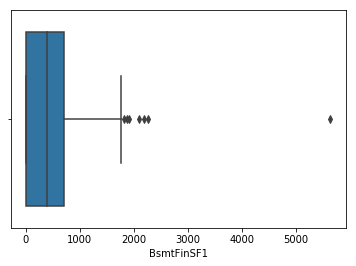

In [52]:
import seaborn as sns
sns.boxplot(x=trainWithoutOutliers['BsmtFinSF1'])


In [54]:
indexNames = trainWithoutOutliers[ trainWithoutOutliers['BsmtFinSF1'] >=3000 ].index
trainWithoutOutliers.drop(indexNames , inplace=True)

In [55]:
Y = np.log1p(trainWithoutOutliers["SalePrice"])
X = trainWithoutOutliers.drop(['SalePrice'],axis=1)


In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=32)

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import r2_score

In [58]:
models=[]

models.append(('RFC',RandomForestRegressor()))

models.append(("GBC",GradientBoostingRegressor()))

In [59]:
names=[]
for name,algo in models:
    algo.fit(X_train,Y_train)
    prediction= algo.predict(X_test)
    a= metrics.mean_squared_error(Y_test,prediction)
    b=r2_score(Y_test, prediction)
    print("%s: %f %f "%(name, a, b))

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RFC: 0.024021 0.843131 
GBC: 0.018198 0.881160 


In [60]:
#newtest = newtest.drop("SalePrice", axis=1)

In [61]:
rfc= GradientBoostingRegressor()
rfc.fit(X_train,Y_train)
pred = np.expm1(rfc.predict(newtest))



In [62]:
sample = pd.read_csv('sample_submission.csv')

In [63]:
sample['SalePrice'] = pred 
sample.to_csv("sample_submission.csv", index=False)